In [ ]:
%pip install torch torchvision torchaudio torch-geometric networkx pandas scikit-learn matplotlib


In [ ]:
%pip install seaborn


In [ ]:
import pandas as pd  # Importing pandas for data manipulation and analysis
import numpy as np  # Importing NumPy for numerical operations
import torch  # Importing PyTorch for building and training neural networks
import torch.nn.functional as F  # Importing functional utilities from PyTorch for activation functions and loss calculations
from torch_geometric.nn import GATConv  # Importing Graph Attention Layer from PyTorch Geometric
from torch_geometric.data import Data  # Importing Data class from PyTorch Geometric for graph data handling
from sklearn.model_selection import train_test_split  # Importing train_test_split for splitting datasets
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score  # Importing metrics for model evaluation
from sklearn.neighbors import NearestNeighbors  # Importing NearestNeighbors for finding neighbors in feature space
from sklearn.decomposition import PCA  # Importing PCA for dimensionality reduction
import seaborn as sns  # Importing Seaborn for statistical data visualization
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting

# Step 5.2.1 Data Preprocessing
# Load the dataset from a CSV file
csv_path = "creditcard.csv"  # Specify the path to your CSV file
data = pd.read_csv(csv_path)  # Read the CSV file into a DataFrame

# Select the first 10000 rows and relevant features
data = data.iloc[:10000, :]  # Take the first 10,000 rows from the DataFrame
features = data.iloc[:, :-1]  # Select all columns except the last one for features
labels = data.iloc[:, -1].values  # Extract the last column as labels (binary classification)

# Normalize the data if necessary
features = (features - features.mean()) / features.std()  # Standardize features by removing the mean and scaling to unit variance

# Train-test split (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42, stratify=labels)
# Splitting the dataset into training (75%) and testing (25%) sets, stratifying by labels to maintain class distribution

# Create edge index based on nearest neighbors
nbrs = NearestNeighbors(n_neighbors=2).fit(X_train)  # Fit NearestNeighbors to training data
edges = nbrs.kneighbors_graph(X_train).toarray()  # Create a graph from the nearest neighbors
edge_index = torch.tensor(np.nonzero(edges)).long()  # Get edge indices from the adjacency matrix

# Convert data to PyTorch tensors
x_train = torch.tensor(X_train.values, dtype=torch.float32)  # Convert features to a PyTorch tensor
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Convert labels to a PyTorch tensor and reshape

# Create PyTorch Geometric Data object
data_train = Data(x=x_train, edge_index=edge_index)  # Create a PyTorch Geometric Data object containing features and edges

# Step 5.2.2 Model Creation
class GAT(torch.nn.Module):  # Define a Graph Attention Network (GAT) model
    def __init__(self, in_channels, out_channels):  # Initialize the model with input and output channel sizes
        super(GAT, self).__init__()  # Call the parent class constructor
        self.gat1 = GATConv(in_channels, 8, heads=1)  # First GAT layer with 8 output features
        self.gat2 = GATConv(8, out_channels, heads=1)  # Second GAT layer with output channels equal to 1

    def forward(self, x, edge_index):  # Define the forward pass
        x = self.gat1(x, edge_index)  # Apply the first GAT layer
        x = F.elu(x)  # Apply ELU activation function
        x = self.gat2(x, edge_index)  # Apply the second GAT layer
        return x  # Return the output of the model

# Initialize the model and optimizer
model = GAT(in_channels=x_train.shape[1], out_channels=1)  # Create an instance of the GAT model
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  # Initialize Adam optimizer with a learning rate

# Step 5.2.3 Model Training
def train():  # Define the training function
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear the gradients
    out = model(data_train.x, data_train.edge_index)  # Forward pass through the model
    
    # Assuming the target is to predict 'Class' as an anomaly score
    target = y_train  # Define the target variable
    loss = F.binary_cross_entropy_with_logits(out, target)  # Calculate the binary cross-entropy loss
    loss.backward()  # Backpropagate the loss
    optimizer.step()  # Update the model parameters
    return loss.item()  # Return the loss value

# Training loop
num_epochs = 100  # Set the number of epochs for training
for epoch in range(num_epochs):  # Iterate over epochs
    loss = train()  # Call the training function
    if (epoch + 1) % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}')  # Output the epoch number and loss

# Step 5.2.4 Model Evaluation
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    x_test = torch.tensor(X_test.values, dtype=torch.float32)  # Convert test features to a tensor
    # Create edges for the test set
    nbrs_test = NearestNeighbors(n_neighbors=2).fit(X_test)  # Fit NearestNeighbors to test data
    edges_test = nbrs_test.kneighbors_graph(X_test).toarray()  # Create a graph from the test data
    edge_index_test = torch.tensor(np.nonzero(edges_test)).long()  # Get edge indices for the test set
    
    out_test = model(x_test, edge_index_test)  # Forward pass through the model for test data
    
    # Apply sigmoid to get probabilities
    predictions = torch.sigmoid(out_test).cpu().numpy()  # Get probabilities by applying sigmoid activation
    predicted_classes = (predictions > 0.5).astype(int)  # Convert probabilities to binary class predictions

# Check unique classes in predicted_classes and y_test
print("Unique classes in predicted predictions:", np.unique(predicted_classes))  # Print unique predicted classes
print("Unique classes in actual test labels:", np.unique(y_test))  # Print unique actual labels

# Ensure y_test is binary
y_test_binary = (y_test > 0.5).astype(int)  # Convert y_test to binary if necessary

# Calculate precision, recall, accuracy, and F1 score
precision = precision_score(y_test_binary, predicted_classes)  # Calculate precision
recall = recall_score(y_test_binary, predicted_classes)  # Calculate recall
accuracy = accuracy_score(y_test_binary, predicted_classes)  # Calculate accuracy
f1 = f1_score(y_test_binary, predicted_classes)  # Calculate F1 score

# Print the results
print(f'Precision: {precision:.4f}')  # Output precision
print(f'Recall: {recall:.4f}')  # Output recall
print(f'Accuracy: {accuracy:.4f}')  # Output accuracy
print(f'F1 Score: {f1:.4f}')  # Output F1 score

# Step 5.2.5 Visualization of the Anomalies using Cluster Map
# PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)  # Initialize PCA to reduce dimensions to 2
X_test_pca = pca.fit_transform(X_test)  # Fit PCA on test data and transform it

# Create a DataFrame for seaborn
df_cluster = pd.DataFrame(X_test_pca, columns=['Feature 1', 'Feature 2'])  # Create a DataFrame with PCA results
df_cluster['Predicted Class'] = predicted_classes  # Add predicted classes to the DataFrame

# Map numeric classes to descriptive labels
df_cluster['Predicted Class'] = df_cluster['Predicted Class'].map({0: 'Normal Transaction', 1: 'Fraud'})  # Map numeric classes to string labels

# Create a cluster map
plt.figure(figsize=(10, 8))  # Set the figure size for the plot
sns.scatterplot(x='Feature 1', y='Feature 2', hue='Predicted Class', data=df_cluster, palette='Set1', alpha=0.7)  # Scatter plot of PCA results colored by predicted class
plt.title('Cluster Map of Predicted Classes on PCA Reduced Test Data')  # Title of the plot
plt.xlabel('Principal Component 1')  # X-axis label
plt.ylabel('Principal Component 2')  # Y-axis label
plt.legend(title='Predicted Class', loc='upper right')  # Add a legend
plt.grid(True)  # Enable grid on the plot
plt.show()  # Display the plot


In [ ]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.preprocessing import StandardScaler

# Step 1: Load the dataset
csv_path = "creditcard.csv"  # Path to the dataset
data = pd.read_csv(csv_path)

# Take the first 10,000 rows
data = data.iloc[:10000, :]

# Define features and target (Class)
features = data.iloc[:, :-1]  # All columns except 'Class'
target = data.iloc[:, -1]  # 'Class' column (fraudulent or not)

# Step 2: Feature Normalization
scaler = StandardScaler()  # Standardizing the features
features_scaled = scaler.fit_transform(features)

# Step 3: Calculate Pairwise Cosine Similarity
cosine_sim = cosine_similarity(features_scaled)  # Cosine similarity between transactions

# Step 4: Construct the Graph (Transaction Similarity Graph)
G = nx.Graph()  # Create an undirected graph

# Add nodes (representing transactions)
for i in range(len(data)):
    G.add_node(i, label=target.iloc[i])

# Add edges based on similarity (only include edges with similarity > threshold)
threshold = 0.9  # Set threshold for similarity (values > 0.9 are considered similar)
for i in range(len(data)):
    for j in range(i+1, len(data)):  # Avoid duplicate edges
        if cosine_sim[i, j] > threshold:
            G.add_edge(i, j, weight=cosine_sim[i, j])

# Step 5: Visualize the Graph using NetworkX
# Generate a layout for the graph (using spring layout)
pos = nx.spring_layout(G, seed=42, k=0.15)  # Adjust k for better node spacing

# Create a color map to color nodes by Class (fraud = 1, normal = 0)
color_map = ['green' if data.iloc[i]['Class'] == 1 else 'red' for i in range(len(data))]

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=color_map, alpha=0.7)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
plt.title("Transaction Similarity Graph (Color-coded by Class: Fraud vs Normal)", fontsize=16)
plt.axis('off')  # Hide axis for better visualization
plt.show()

# Step 6: Dimensionality Reduction (PCA) for Better Visualization
pca = PCA(n_components=2)  # Reduce to 2D for easier visualization
features_pca = pca.fit_transform(features_scaled)

# Visualize the PCA-reduced features with fraud classification
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=target, palette='RdYlGn', alpha=0.7, s=60)
plt.title("PCA Projection of Transactions (Fraud vs Normal)", fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
%pip install imblearn

In [ ]:
import pandas as pd

# Load the dataset
csv_path = "creditcard.csv"  # Path to the dataset
data = pd.read_csv(csv_path)

# Take the first 10,000 rows
data = data.iloc[20001:30000, :]

# Count how many '1's (fraudulent transactions) are in the 'Class' column
fraud_count = data['Class'].sum()

# Print the result
print(f"Number of fraudulent transactions (Class = 1) in the first 10,000 transactions: {fraud_count}")


C:\Users\Nusla\AppData\Local\Temp\ipykernel_3876\505562070.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_index_train = torch.tensor(np.nonzero(edges_train)).long()  # Get edge indices from the adjacency matrix


Training with lr=0.005, hidden_channels=8, num_heads=1, dropout=0.3
Training with lr=0.005, hidden_channels=8, num_heads=1, dropout=0.5
Training with lr=0.005, hidden_channels=8, num_heads=1, dropout=0.7
Training with lr=0.005, hidden_channels=8, num_heads=2, dropout=0.3
Training with lr=0.005, hidden_channels=8, num_heads=2, dropout=0.5
Training with lr=0.005, hidden_channels=8, num_heads=2, dropout=0.7
Training with lr=0.005, hidden_channels=8, num_heads=4, dropout=0.3
Training with lr=0.005, hidden_channels=8, num_heads=4, dropout=0.5
Training with lr=0.005, hidden_channels=8, num_heads=4, dropout=0.7
Training with lr=0.005, hidden_channels=16, num_heads=1, dropout=0.3
Training with lr=0.005, hidden_channels=16, num_heads=1, dropout=0.5
Training with lr=0.005, hidden_channels=16, num_heads=1, dropout=0.7
Training with lr=0.005, hidden_channels=16, num_heads=2, dropout=0.3
Training with lr=0.005, hidden_channels=16, num_heads=2, dropout=0.5
Training with lr=0.005, hidden_channels=16,

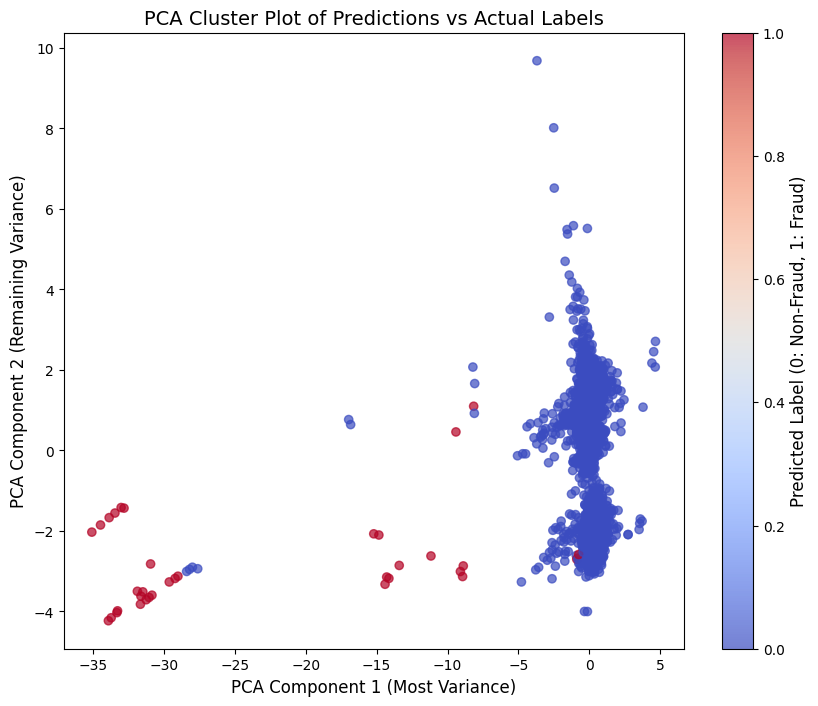

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset from a CSV file
csv_path = "creditcard.csv"  # Specify the path to your CSV file
data = pd.read_csv(csv_path)  # Read the CSV file into a DataFrame

# Select the first 30,000 rows and relevant features
data = data.iloc[:30000, :]  # Take the first 30,000 rows from the DataFrame
features = data.iloc[:, :-1]  # Select all columns except the last one for features
labels = data.iloc[:, -1].values  # Extract the last column as labels (binary classification)

# Normalize the data
features = (features - features.mean()) / features.std()  # Standardize features by removing the mean and scaling to unit variance

# Train-test split (Train: 0-19999, Test: 20000-29999)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.333, random_state=42, stratify=labels)

# Create Graph (for visualization)
nbrs_train = NearestNeighbors(n_neighbors=2).fit(X_train)  # Fit NearestNeighbors to the original training data
edges_train = nbrs_train.kneighbors_graph(X_train).toarray()  # Create a graph from the training data
edge_index_train = torch.tensor(np.nonzero(edges_train)).long()  # Get edge indices from the adjacency matrix

# Convert data to PyTorch tensors
x_train = torch.tensor(X_train.values, dtype=torch.float32)  # Convert features to a PyTorch tensor (now using `.values` to convert to NumPy array)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Convert labels to a PyTorch tensor and reshape

# Create PyTorch Geometric Data object for training
data_train = Data(x=x_train, edge_index=edge_index_train)

# Step 5.2.3 Model Creation (GAT)
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=8, num_heads=1, dropout=0.5):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * num_heads, out_channels, heads=1, dropout=dropout)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x

# Hyperparameter tuning: Adjust learning rate, number of heads, hidden channels, dropout rate, etc.
learning_rates = [0.005, 0.01, 0.001]
hidden_channels_options = [8, 16, 32]
num_heads_options = [1, 2, 4]
dropout_rates = [0.3, 0.5, 0.7]

best_f1_score = 0
best_params = {}

# Iterate through hyperparameters and evaluate performance
for lr in learning_rates:
    for hidden_channels in hidden_channels_options:
        for num_heads in num_heads_options:
            for dropout in dropout_rates:
                print(f"Training with lr={lr}, hidden_channels={hidden_channels}, num_heads={num_heads}, dropout={dropout}")
                
                # Initialize the model and optimizer
                model = GAT(in_channels=x_train.shape[1], out_channels=1, hidden_channels=hidden_channels, num_heads=num_heads, dropout=dropout)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Training loop
                num_epochs = 50
                for epoch in range(num_epochs):
                    model.train()
                    optimizer.zero_grad()
                    out = model(data_train.x, data_train.edge_index)
                    loss = F.binary_cross_entropy_with_logits(out, y_train)
                    loss.backward()
                    optimizer.step()

                # Evaluate the model
                model.eval()
                with torch.no_grad():
                    x_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
                    nbrs_test = NearestNeighbors(n_neighbors=2).fit(X_test)
                    edges_test = nbrs_test.kneighbors_graph(X_test).toarray()
                    edge_index_test = torch.tensor(np.nonzero(edges_test)).long()

                    out_test = model(x_test_tensor, edge_index_test)
                    predictions = torch.sigmoid(out_test).cpu().numpy()
                    predicted_classes = (predictions > 0.5).astype(int)

                # Calculate precision, recall, accuracy, and F1 score
                f1 = f1_score(y_test, predicted_classes)

                # Track the best model based on F1 score
                if f1 > best_f1_score:
                    best_f1_score = f1
                    best_params = {
                        'lr': lr,
                        'hidden_channels': hidden_channels,
                        'num_heads': num_heads,
                        'dropout': dropout
                    }

print("Best Hyperparameters:", best_params)
print(f"Best F1 Score: {best_f1_score:.4f}")

# Final model training with best hyperparameters
best_lr = best_params['lr']
best_hidden_channels = best_params['hidden_channels']
best_num_heads = best_params['num_heads']
best_dropout = best_params['dropout']

# Initialize the best model and optimizer
model = GAT(in_channels=x_train.shape[1], out_channels=1, hidden_channels=best_hidden_channels, num_heads=best_num_heads, dropout=best_dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

# Train the final model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data_train.x, data_train.edge_index)
    loss = F.binary_cross_entropy_with_logits(out, y_train)
    loss.backward()
    optimizer.step()

# Evaluate the final model
model.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    nbrs_test = NearestNeighbors(n_neighbors=2).fit(X_test)
    edges_test = nbrs_test.kneighbors_graph(X_test).toarray()
    edge_index_test = torch.tensor(np.nonzero(edges_test)).long()

    out_test = model(x_test_tensor, edge_index_test)
    predictions = torch.sigmoid(out_test).cpu().numpy()
    predicted_classes = (predictions > 0.5).astype(int)

# Calculate final precision, recall, accuracy, and F1 score
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
accuracy = accuracy_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)

# Print the results
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final Accuracy: {accuracy:.4f}')
print(f'Final F1 Score: {f1:.4f}')

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Visualization: Cluster Plot of Predictions vs Actual Labels using PCA
plt.figure(figsize=(10, 8))

# Scatter plot
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=predicted_classes, cmap='coolwarm', alpha=0.7)

# Add title and labels
plt.title("PCA Cluster Plot of Predictions vs Actual Labels", fontsize=14)
plt.xlabel("PCA Component 1 (Most Variance)", fontsize=12)
plt.ylabel("PCA Component 2 (Remaining Variance)", fontsize=12)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Predicted Label (0: Non-Fraud, 1: Fraud)', fontsize=12)



plt.show()


5.1.1 Data Preprocessing


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Load the dataset from a CSV file
csv_path = "creditcard.csv"  # the path to CSV file
data = pd.read_csv(csv_path)  # Read the CSV file into a DataFrame

# Select the first 30,000 rows and relevant features
data = data.iloc[:30000, :]  # Take the first 30,000 rows from the DataFrame
features = data.iloc[:, :-1]  # Select all columns except the last one for features
labels = data.iloc[:, -1].values  # Extract the last column as labels (binary classification)

# Normalize the data
scaler = StandardScaler()
features = scaler.fit_transform(features)  # Standardize features by removing the mean and scaling to unit variance

# Train-test split (Train: 0-19999, Test: 20000-29999)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.333, random_state=42, stratify=labels)

# Create Graph (for visualization and graph-based model)
nbrs_train = NearestNeighbors(n_neighbors=2).fit(X_train)  # Fit NearestNeighbors to the original training data
edges_train = nbrs_train.kneighbors_graph(X_train).toarray()  # Create a graph from the training data
edge_index_train = torch.tensor(np.nonzero(edges_train)).long()  # Get edge indices from the adjacency matrix

# Convert data to PyTorch tensors
x_train = torch.tensor(X_train, dtype=torch.float32)  # Convert features to a PyTorch tensor
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Convert labels to a PyTorch tensor and reshape


5.1.2 Model Building

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=8, num_heads=1, dropout=0.5):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=dropout) #First layer
        self.gat2 = GATConv(hidden_channels * num_heads, out_channels, heads=1, dropout=dropout) #Second layer

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)  # ELU activation
        x = self.gat2(x, edge_index)
        return x


5.1.3 Model Training with best hyperparameters

In [ ]:
import torch.optim as optim
from sklearn.metrics import f1_score

# Hyperparameters (you can adjust these as needed)
learning_rates = [0.005, 0.01, 0.001]
hidden_channels_options = [8, 16, 32]
num_heads_options = [1, 2, 4]
dropout_rates = [0.3, 0.5, 0.7]

best_f1_score = 0
best_params = {}

# Iterate through hyperparameters and evaluate performance
for lr in learning_rates:
    for hidden_channels in hidden_channels_options:
        for num_heads in num_heads_options:
            for dropout in dropout_rates:
                print(f"Training with lr={lr}, hidden_channels={hidden_channels}, num_heads={num_heads}, dropout={dropout}")
                
                # Initialize the model and optimizer
                model = GAT(in_channels=x_train.shape[1], out_channels=1, hidden_channels=hidden_channels, num_heads=num_heads, dropout=dropout)
                optimizer = optim.Adam(model.parameters(), lr=lr)

                # Training loop
                num_epochs = 50
                for epoch in range(num_epochs):
                    model.train()
                    optimizer.zero_grad()
                    out = model(x_train, edge_index_train)  # Forward pass
                    loss = F.binary_cross_entropy_with_logits(out, y_train)  # Compute loss
                    loss.backward()  # Backward pass
                    optimizer.step()  # Update weights

                # Evaluate the model on test data
                model.eval()
                with torch.no_grad():
                    x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
                    nbrs_test = NearestNeighbors(n_neighbors=2).fit(X_test)
                    edges_test = nbrs_test.kneighbors_graph(X_test).toarray()
                    edge_index_test = torch.tensor(np.nonzero(edges_test)).long()

                    out_test = model(x_test_tensor, edge_index_test)
                    predictions = torch.sigmoid(out_test).cpu().numpy()
                    predicted_classes = (predictions > 0.5).astype(int)

                # Calculate F1 score
                f1 = f1_score(y_test, predicted_classes)

                # Track the best model based on F1 score
                if f1 > best_f1_score:
                    best_f1_score = f1
                    best_params = {
                        'lr': lr,
                        'hidden_channels': hidden_channels,
                        'num_heads': num_heads,
                        'dropout': dropout
                    }

print("Best Hyperparameters:", best_params)
print(f"Best F1 Score: {best_f1_score:.4f}")

# Final model training with best hyperparameters
best_lr = best_params['lr']
best_hidden_channels = best_params['hidden_channels']
best_num_heads = best_params['num_heads']
best_dropout = best_params['dropout']

# Initialize the best model and optimizer
model = GAT(in_channels=x_train.shape[1], out_channels=1, hidden_channels=best_hidden_channels, num_heads=best_num_heads, dropout=best_dropout)
optimizer = optim.Adam(model.parameters(), lr=best_lr)

# Train the final model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(x_train, edge_index_train)  # Forward pass
    loss = F.binary_cross_entropy_with_logits(out, y_train)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

5.1.4 Model Evaluation

In [ ]:
# Evaluate the final model
model.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    nbrs_test = NearestNeighbors(n_neighbors=2).fit(X_test)
    edges_test = nbrs_test.kneighbors_graph(X_test).toarray()
    edge_index_test = torch.tensor(np.nonzero(edges_test)).long()

    out_test = model(x_test_tensor, edge_index_test)
    predictions = torch.sigmoid(out_test).cpu().numpy()
    predicted_classes = (predictions > 0.5).astype(int)

# Calculate final precision, recall, accuracy, and F1 score
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
accuracy = accuracy_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)

# Print the results
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final Accuracy: {accuracy:.4f}')
print(f'Final F1 Score: {f1:.4f}')


5.1.5 Visualization of anomalies


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix

# Apply PCA for dimensionality reduction to 2D (for visualization purposes)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Visualizing the Clustering of Predictions vs Actual Labels using PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=predicted_classes, cmap='coolwarm', alpha=0.7)
plt.title("PCA Cluster Plot of Predictions vs Actual Labels", fontsize=14)
plt.xlabel("PCA Component 1 (Most Variance)", fontsize=12)
plt.ylabel("PCA Component 2 (Remaining Variance)", fontsize=12)
cbar = plt.colorbar(scatter)
cbar.set_label('Predicted Label (0: Non-Fraud, 1: Fraud)', fontsize=12)
plt.show()

# --- Confusion Matrix Visualization ---
cm = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix for Fraud Detection", fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, predictions)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='blue', label='Precision-Recall curve')
plt.fill_between(recall_vals, precision_vals, color='skyblue', alpha=0.3)
plt.title("Precision-Recall Curve", fontsize=14)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(loc="lower left")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.show()


Training with lr=0.005, hidden_channels=8, num_heads=1, dropout=0.3
Training with lr=0.005, hidden_channels=8, num_heads=1, dropout=0.5
Training with lr=0.005, hidden_channels=8, num_heads=1, dropout=0.7
Training with lr=0.005, hidden_channels=8, num_heads=2, dropout=0.3
Training with lr=0.005, hidden_channels=8, num_heads=2, dropout=0.5
Training with lr=0.005, hidden_channels=8, num_heads=2, dropout=0.7
Training with lr=0.005, hidden_channels=8, num_heads=4, dropout=0.3
Training with lr=0.005, hidden_channels=8, num_heads=4, dropout=0.5
Training with lr=0.005, hidden_channels=8, num_heads=4, dropout=0.7
Training with lr=0.005, hidden_channels=16, num_heads=1, dropout=0.3
Training with lr=0.005, hidden_channels=16, num_heads=1, dropout=0.5
Training with lr=0.005, hidden_channels=16, num_heads=1, dropout=0.7
Training with lr=0.005, hidden_channels=16, num_heads=2, dropout=0.3
Training with lr=0.005, hidden_channels=16, num_heads=2, dropout=0.5
Training with lr=0.005, hidden_channels=16,

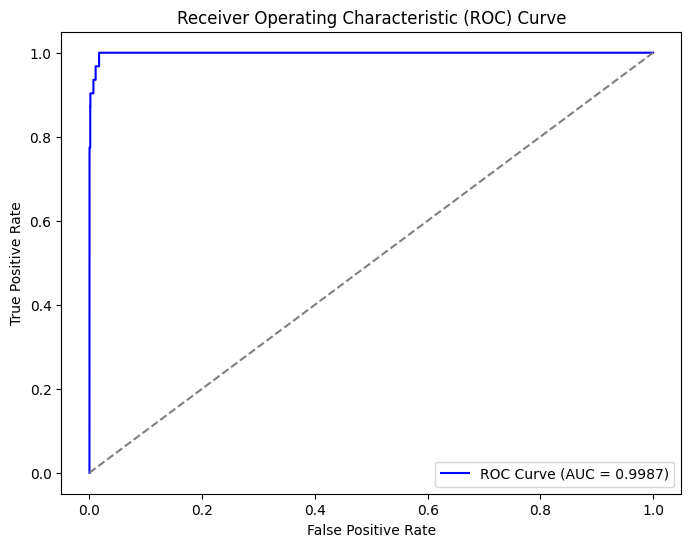

AUC Score: 0.9987


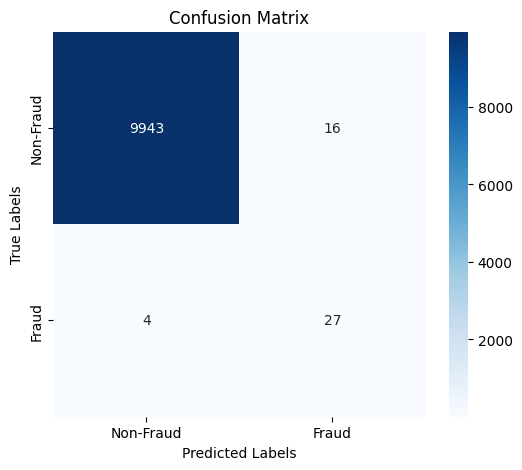

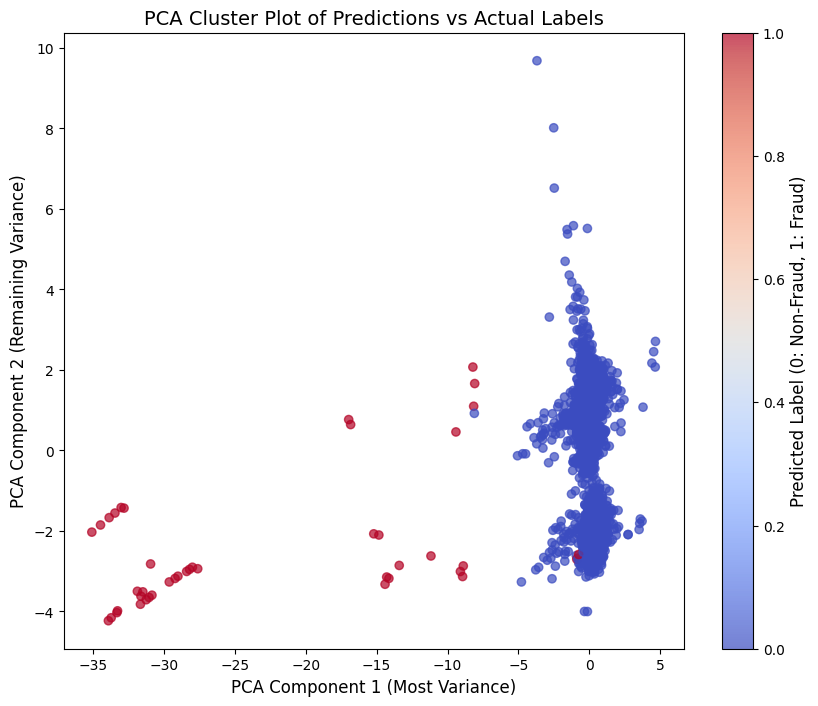

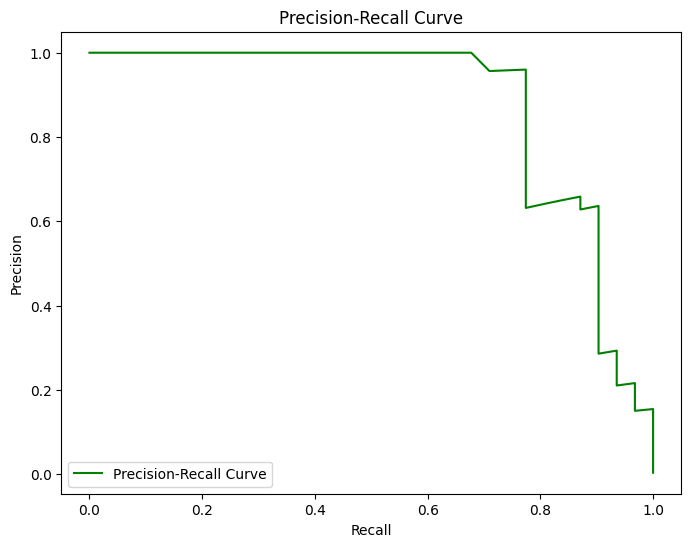


Summary of Model Performance Metrics:
      Metric     Score
0  Precision  0.627907
1     Recall  0.870968
2   Accuracy  0.997998
3   F1 Score  0.729730
4        AUC  0.998674


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset from a CSV file
csv_path = "creditcard.csv"  # Specify the path to your CSV file
data = pd.read_csv(csv_path)  # Read the CSV file into a DataFrame

# Select the first 30,000 rows and relevant features
data = data.iloc[:30000, :]  # Take the first 30,000 rows from the DataFrame
features = data.iloc[:, :-1]  # Select all columns except the last one for features
labels = data.iloc[:, -1].values  # Extract the last column as labels (binary classification)

# Normalize the data
features = (features - features.mean()) / features.std()  # Standardize features by removing the mean and scaling to unit variance

# Train-test split (Train: 0-19999, Test: 20000-29999)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.333, random_state=42, stratify=labels)

# Create Graph (for visualization)
nbrs_train = NearestNeighbors(n_neighbors=2).fit(X_train)  # Fit NearestNeighbors to the original training data
edges_train = nbrs_train.kneighbors_graph(X_train).toarray()  # Create a graph from the training data
edge_index_train = torch.tensor(np.nonzero(edges_train)).long()  # Get edge indices from the adjacency matrix

# Convert data to PyTorch tensors
x_train = torch.tensor(X_train.values, dtype=torch.float32)  # Convert features to a PyTorch tensor (now using `.values` to convert to NumPy array)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Convert labels to a PyTorch tensor and reshape

# Create PyTorch Geometric Data object for training
data_train = Data(x=x_train, edge_index=edge_index_train)

# Step 5.2.3 Model Creation (GAT)
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=8, num_heads=1, dropout=0.5):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * num_heads, out_channels, heads=1, dropout=dropout)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x

# Hyperparameter tuning: Adjust learning rate, number of heads, hidden channels, dropout rate, etc.
learning_rates = [0.005, 0.01, 0.001]
hidden_channels_options = [8, 16, 32]
num_heads_options = [1, 2, 4]
dropout_rates = [0.3, 0.5, 0.7]

best_f1_score = 0
best_params = {}

# Iterate through hyperparameters and evaluate performance
for lr in learning_rates:
    for hidden_channels in hidden_channels_options:
        for num_heads in num_heads_options:
            for dropout in dropout_rates:
                print(f"Training with lr={lr}, hidden_channels={hidden_channels}, num_heads={num_heads}, dropout={dropout}")
                
                # Initialize the model and optimizer
                model = GAT(in_channels=x_train.shape[1], out_channels=1, hidden_channels=hidden_channels, num_heads=num_heads, dropout=dropout)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Training loop
                num_epochs = 50
                for epoch in range(num_epochs):
                    model.train()
                    optimizer.zero_grad()
                    out = model(data_train.x, data_train.edge_index)
                    loss = F.binary_cross_entropy_with_logits(out, y_train)
                    loss.backward()
                    optimizer.step()

                # Evaluate the model
                model.eval()
                with torch.no_grad():
                    x_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
                    nbrs_test = NearestNeighbors(n_neighbors=2).fit(X_test)
                    edges_test = nbrs_test.kneighbors_graph(X_test).toarray()
                    edge_index_test = torch.tensor(np.nonzero(edges_test)).long()

                    out_test = model(x_test_tensor, edge_index_test)
                    predictions = torch.sigmoid(out_test).cpu().numpy()
                    predicted_classes = (predictions > 0.5).astype(int)

                # Calculate precision, recall, accuracy, and F1 score
                f1 = f1_score(y_test, predicted_classes)

                # Track the best model based on F1 score
                if f1 > best_f1_score:
                    best_f1_score = f1
                    best_params = {
                        'lr': lr,
                        'hidden_channels': hidden_channels,
                        'num_heads': num_heads,
                        'dropout': dropout
                    }

print("Best Hyperparameters:", best_params)
print(f"Best F1 Score: {best_f1_score:.4f}")

# Final model training with best hyperparameters
best_lr = best_params['lr']
best_hidden_channels = best_params['hidden_channels']
best_num_heads = best_params['num_heads']
best_dropout = best_params['dropout']

# Initialize the best model and optimizer
model = GAT(in_channels=x_train.shape[1], out_channels=1, hidden_channels=best_hidden_channels, num_heads=best_num_heads, dropout=best_dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

# Train the final model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data_train.x, data_train.edge_index)
    loss = F.binary_cross_entropy_with_logits(out, y_train)
    loss.backward()
    optimizer.step()

# Evaluate the final model
model.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    nbrs_test = NearestNeighbors(n_neighbors=2).fit(X_test)
    edges_test = nbrs_test.kneighbors_graph(X_test).toarray()
    edge_index_test = torch.tensor(np.nonzero(edges_test)).long()

    out_test = model(x_test_tensor, edge_index_test)
    predictions = torch.sigmoid(out_test).cpu().numpy()
    predicted_classes = (predictions > 0.5).astype(int)

# Calculate final precision, recall, accuracy, and F1 score
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
accuracy = accuracy_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)

# Print the results
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final Accuracy: {accuracy:.4f}')
print(f'Final F1 Score: {f1:.4f}')

# 1. ROC Curve and AUC Calculation
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print(f"AUC Score: {roc_auc:.4f}")

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 3. PCA Visualization (Cluster Plot)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Scatter plot for PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=predicted_classes, cmap='coolwarm', alpha=0.7)
plt.title("PCA Cluster Plot of Predictions vs Actual Labels", fontsize=14)
plt.xlabel("PCA Component 1 (Most Variance)", fontsize=12)
plt.ylabel("PCA Component 2 (Remaining Variance)", fontsize=12)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Predicted Label (0: Non-Fraud, 1: Fraud)', fontsize=12)

plt.show()

# 4. Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, predictions)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='green', label=f'Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Summary of Final Metrics
metrics_summary = pd.DataFrame({
    "Metric": ["Precision", "Recall", "Accuracy", "F1 Score", "AUC"],
    "Score": [precision, recall, accuracy, f1, roc_auc]
})
print("\nSummary of Model Performance Metrics:")
print(metrics_summary)


Training with lr=0.005, hidden_channels=8, num_heads=1, dropout=0.3
Training with lr=0.005, hidden_channels=8, num_heads=1, dropout=0.5
Training with lr=0.005, hidden_channels=8, num_heads=1, dropout=0.7
Training with lr=0.005, hidden_channels=8, num_heads=2, dropout=0.3
Training with lr=0.005, hidden_channels=8, num_heads=2, dropout=0.5
Training with lr=0.005, hidden_channels=8, num_heads=2, dropout=0.7
Training with lr=0.005, hidden_channels=8, num_heads=4, dropout=0.3
Training with lr=0.005, hidden_channels=8, num_heads=4, dropout=0.5
Training with lr=0.005, hidden_channels=8, num_heads=4, dropout=0.7
Training with lr=0.005, hidden_channels=16, num_heads=1, dropout=0.3
Training with lr=0.005, hidden_channels=16, num_heads=1, dropout=0.5
Training with lr=0.005, hidden_channels=16, num_heads=1, dropout=0.7
Training with lr=0.005, hidden_channels=16, num_heads=2, dropout=0.3
Training with lr=0.005, hidden_channels=16, num_heads=2, dropout=0.5
Training with lr=0.005, hidden_channels=16,

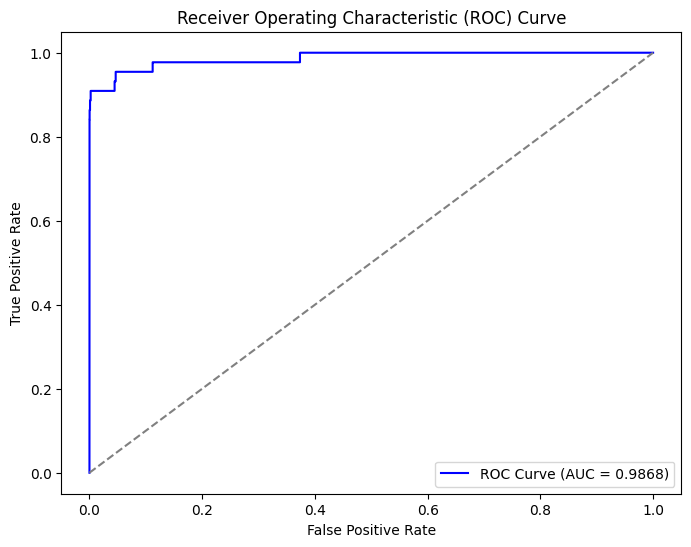

AUC Score: 0.9868


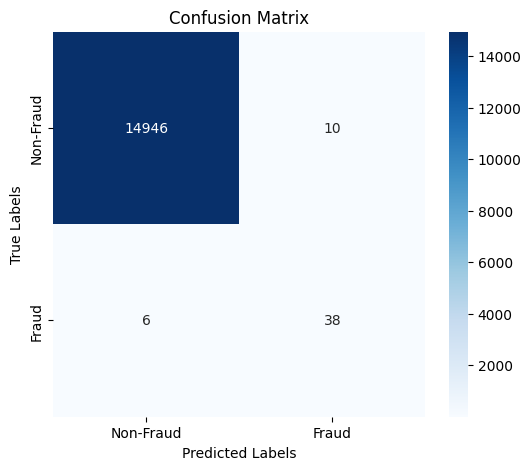

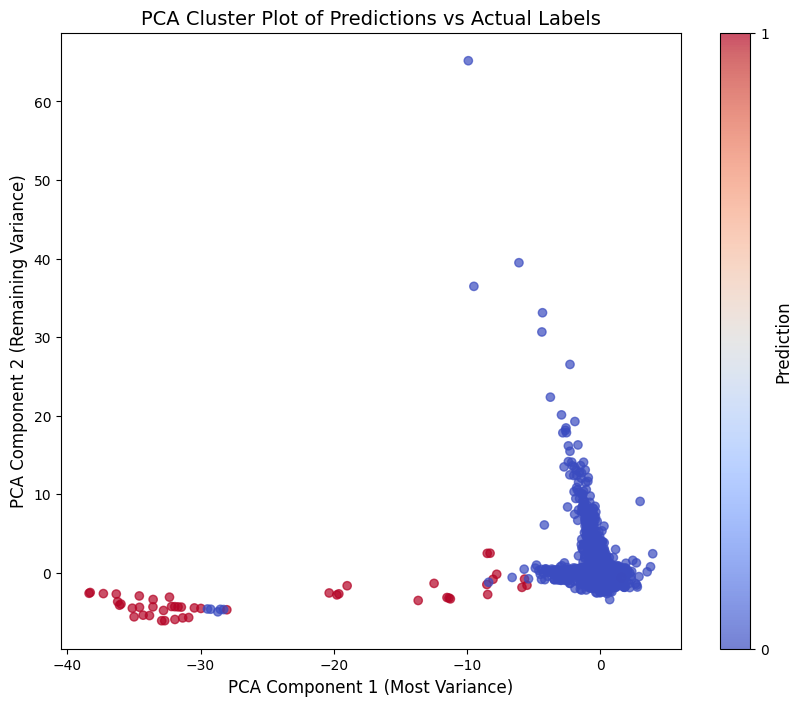

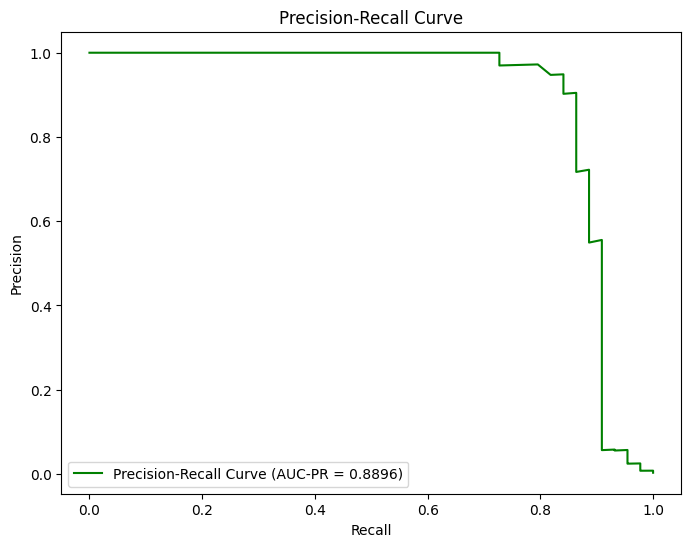

AUC-PR Score: 0.8896

Summary of Model Performance Metrics:
      Metric     Score
0  Precision  0.791667
1     Recall  0.863636
2   Accuracy  0.998933
3   F1 Score  0.826087
4        AUC  0.986804
5     AUC-PR  0.889557


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset from a CSV file
csv_path = "creditcard.csv"  # Specify the path to your CSV file
data = pd.read_csv(csv_path)  # Read the CSV file into a DataFrame

# Select the first 50,000 rows and relevant features
data = data.iloc[:50000, :]  # Take the first 50,000 rows from the DataFrame
features = data.iloc[:, :-1]  # Select all columns except the last one for features
labels = data.iloc[:, -1].values  # Extract the last column as labels (binary classification)

# Normalize the data
features = (features - features.mean()) / features.std()  # Standardize features by removing the mean and scaling to unit variance

# Train-test split (Train: 0-34999, Test: 35000-49999)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)

# Create Graph (for visualization)
nbrs_train = NearestNeighbors(n_neighbors=2).fit(X_train)  # Fit NearestNeighbors to the original training data
edges_train = nbrs_train.kneighbors_graph(X_train).toarray()  # Create a graph from the training data
edge_index_train = torch.tensor(np.nonzero(edges_train)).long()  # Get edge indices from the adjacency matrix

# Convert data to PyTorch tensors
x_train = torch.tensor(X_train.values, dtype=torch.float32)  # Convert features to a PyTorch tensor (now using `.values` to convert to NumPy array)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Convert labels to a PyTorch tensor and reshape

# Create PyTorch Geometric Data object for training
data_train = Data(x=x_train, edge_index=edge_index_train)

# Step 5.2.3 Model Creation (GAT)
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=8, num_heads=1, dropout=0.5):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * num_heads, out_channels, heads=1, dropout=dropout)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x

# Hyperparameter tuning: Adjust learning rate, number of heads, hidden channels, dropout rate, etc.
learning_rates = [0.005, 0.01, 0.001]
hidden_channels_options = [8, 16, 32]
num_heads_options = [1, 2, 4]
dropout_rates = [0.3, 0.5, 0.7]

best_f1_score = 0
best_params = {}

# Iterate through hyperparameters and evaluate performance
for lr in learning_rates:
    for hidden_channels in hidden_channels_options:
        for num_heads in num_heads_options:
            for dropout in dropout_rates:
                print(f"Training with lr={lr}, hidden_channels={hidden_channels}, num_heads={num_heads}, dropout={dropout}")
                
                # Initialize the model and optimizer
                model = GAT(in_channels=x_train.shape[1], out_channels=1, hidden_channels=hidden_channels, num_heads=num_heads, dropout=dropout)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Training loop
                num_epochs = 50
                for epoch in range(num_epochs):
                    model.train()
                    optimizer.zero_grad()
                    out = model(data_train.x, data_train.edge_index)
                    loss = F.binary_cross_entropy_with_logits(out, y_train)
                    loss.backward()
                    optimizer.step()

                # Evaluate the model
                model.eval()
                with torch.no_grad():
                    x_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
                    nbrs_test = NearestNeighbors(n_neighbors=2).fit(X_test)
                    edges_test = nbrs_test.kneighbors_graph(X_test).toarray()
                    edge_index_test = torch.tensor(np.nonzero(edges_test)).long()

                    out_test = model(x_test_tensor, edge_index_test)
                    predictions = torch.sigmoid(out_test).cpu().numpy()
                    predicted_classes = (predictions > 0.5).astype(int)

                # Calculate precision, recall, accuracy, and F1 score
                f1 = f1_score(y_test, predicted_classes)

                # Track the best model based on F1 score
                if f1 > best_f1_score:
                    best_f1_score = f1
                    best_params = {
                        'lr': lr,
                        'hidden_channels': hidden_channels,
                        'num_heads': num_heads,
                        'dropout': dropout
                    }

print("Best Hyperparameters:", best_params)
print(f"Best F1 Score: {best_f1_score:.4f}")

# Final model training with best hyperparameters
best_lr = best_params['lr']
best_hidden_channels = best_params['hidden_channels']
best_num_heads = best_params['num_heads']
best_dropout = best_params['dropout']

# Initialize the best model and optimizer
model = GAT(in_channels=x_train.shape[1], out_channels=1, hidden_channels=best_hidden_channels, num_heads=best_num_heads, dropout=best_dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

# Train the final model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data_train.x, data_train.edge_index)
    loss = F.binary_cross_entropy_with_logits(out, y_train)
    loss.backward()
    optimizer.step()

# Evaluate the final model
model.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    nbrs_test = NearestNeighbors(n_neighbors=2).fit(X_test)
    edges_test = nbrs_test.kneighbors_graph(X_test).toarray()
    edge_index_test = torch.tensor(np.nonzero(edges_test)).long()

    out_test = model(x_test_tensor, edge_index_test)
    predictions = torch.sigmoid(out_test).cpu().numpy()
    predicted_classes = (predictions > 0.5).astype(int)

# Calculate final precision, recall, accuracy, F1 score
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
accuracy = accuracy_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)

# Print the results
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final Accuracy: {accuracy:.4f}')
print(f'Final F1 Score: {f1:.4f}')

# 1. ROC Curve and AUC Calculation
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print(f"AUC Score: {roc_auc:.4f}")

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 3. PCA Visualization (Cluster Plot)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Scatter plot for PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=predicted_classes, cmap='coolwarm', alpha=0.7)
plt.title("PCA Cluster Plot of Predictions vs Actual Labels", fontsize=14)
plt.xlabel("PCA Component 1 (Most Variance)", fontsize=12)
plt.ylabel("PCA Component 2 (Remaining Variance)", fontsize=12)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_ticks([0, 1])
cbar.set_label('Prediction', fontsize=12)

plt.show()

# 4. Precision-Recall Curve and AUC-PR
precision_vals, recall_vals, _ = precision_recall_curve(y_test, predictions)
auc_pr = average_precision_score(y_test, predictions)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='green', label=f'Precision-Recall Curve (AUC-PR = {auc_pr:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Print AUC-PR
print(f"AUC-PR Score: {auc_pr:.4f}")

# Summary of Model Performance
metrics_summary = pd.DataFrame({
    "Metric": ["Precision", "Recall", "Accuracy", "F1 Score", "AUC", "AUC-PR"],
    "Score": [precision, recall, accuracy, f1, roc_auc, auc_pr]
})

print("\nSummary of Model Performance Metrics:")
print(metrics_summary)
